#CS224S Assignment 3 Warm Up
##HarperValleyBank Data Exploration & CTC Implementation


This notebook is worth 30 points out of the total 100 points for Homework 3. Don't forget to work on the neural network training Colab after this one! See the assignment handout on the course website for submission instructions. 

## Setup for Google Drive and Required Libraries

You will need to make a copy of this Colab notebook in your Google Drive before you can edit the homework files.

You can do so with **File &rarr; Save a copy in Drive**.


In [ ]:
#@markdown Your work will be stored in a folder called `cs224s_spring2022` by default to prevent Colab instance timeouts from deleting your edits and requiring you to redownload your data.
#@markdown f
#@markdown When asked, authenticate connecting your Drive to the notebook and give all the necessary permissions.


import os
from google.colab import drive
drive.mount('/content/gdrive')

#@title set up mount symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/cs224s_spring2022'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

SYM_PATH = '/content/cs224s_spring2022'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

In [ ]:
#@title Download HarperValleyBank dataset
#@markdown It takes ~10 minutes to download the dataset. You only need to do this once!

DATA_PATH = '{}/data'.format(SYM_PATH)
if not os.path.exists(DATA_PATH):
  %mkdir $DATA_PATH
%cd $DATA_PATH
if not os.path.exists(os.path.join(DATA_PATH, 'harpervalleybank')):
  !wget -q http://web.stanford.edu/class/cs224s/download/harpervalleybank.zip
  !unzip -q harpervalleybank.zip
  %rm harpervalleybank.zip

In [2]:
!pip install nltk


C:\Users\Phuc\Desktop\CS224S-slp\HW3>doskey make=mingw32-make.exe 
     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
      --------------------------------------- 0.0/1.5 MB 325.1 kB/s eta 0:00:05
     - -------------------------------------- 0.1/1.5 MB 544.7 kB/s eta 0:00:03
     --- ------------------------------------ 0.1/1.5 MB 853.3 kB/s eta 0:00:02
     ----- ---------------------------------- 0.2/1.5 MB 958.4 kB/s eta 0:00:02
     --------- ------------------------------ 0.3/1.5 MB 1.3 MB/s eta 0:00:01
     ------------ --------------------------- 0.5/1.5 MB 1.5 MB/s eta 0:00:01
     --------------- ------------------------ 0.6/1.5 MB 1.6 MB/s eta 0:00:01
     ------------------- -------------------- 0.7/1.5 MB 1.8 MB/s eta 0:00:01
     --------------------- ------------------ 0.8/1.5 MB 1.8 MB/s eta 0:00:01
     ------------------------- -------------- 1.0/1.5 MB 1.9 MB/s eta 0:00:01
  

In [3]:
#@title Import packages
import nltk
nltk.download('punkt')
import os
from nltk.tokenize import word_tokenize

import json
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import matplotlib.pyplot as plt
from typing import Tuple
import torch

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Phuc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


## Part 1:  HarperValleyBank Dataset Exploration

Let's first explore the [HarperValleyBank](https://arxiv.org/abs/2010.13929) dataset! The dataset primarily consists of simulated telephone/app-based consumer to banker interactions. For any new dataset, it is generally a good idea to explore the "shape" and "properties" of the data. This will help greatly when debugging unexpected behavior in your speech system.






## Getting Corpus Statistics

For any new dataset, it is generally a good idea to explore the "shape" and "properties" of the data. This will help greatly when debugging unexpected behavior in your speech system. 

The structure of the HarperValleyBank dataset is:
```
data
    audio
        agent
            <sid1>.wav
            <sid2>.wav
            ...
        caller
            <sid1>.wav
            <sid2>.wav
            ...
    metadata
        <sid1>.json
        <sid2>.json
        ...
    transcript
        <sid1>.json
        <sid2>.json
        ...
```
Every consumer-banker conversation has an id referred to as it' `sid ` .  All associated files are named based on that sid.
Each conversation has four associated files, two audio files, one transcript file and one metadata file.
The audio for each conversation is divided in to two single channel wav files, available under the audio/agent and audio/caller directories.

##### <ins>**Task 1.1.1**</ins>: **Number of conversations** **(2 points)**

Please fill out the function `number_of_conversations` to get the number of conversations in the dataset. (This part could be done with 1 line of code)


In [4]:
agent_audio_path = 'harpervalleybank/audio/agent/'
caller_audio_path = 'harpervalleybank/audio/caller/'
transcript_path = 'harpervalleybank/transcript/'
metadata_path = 'harpervalleybank/metadata/'

def number_of_conversations(path: str) -> int:
  """Gets number of conversations in the dataset.

  Args:
    path: Path to relevant directory.

  Returns:
    Number of conversations.
  """
  #############################
  #### YOUR CODE GOES HERE ####
  return len(os.listdir(path))
  #############################   

path = transcript_path 
print('Number of conversations: ' + str(number_of_conversations(path)))

Number of conversations: 1446


[link text](https://)##### <ins>**Task 1.1</ins>: Plot call duration (3 points)**

Please fill out the function `recording_time` to get the durations and total duration of recording in seconds and plot a histogram with duration of recording (in seconds) as x-axis and count of conversations as y-axis. You can use `wavfile.read()` method to read files. 

For a single conversation, there are two audio files: `caller` and `agent` audio files. Both audio files for the same conversation have the same duration of recording because the other person's voice is replaced with silence. Thus, please choose either caller or agent directory to get the total duration or recording. 


Duration of recordings in seconds 84132.95000000008


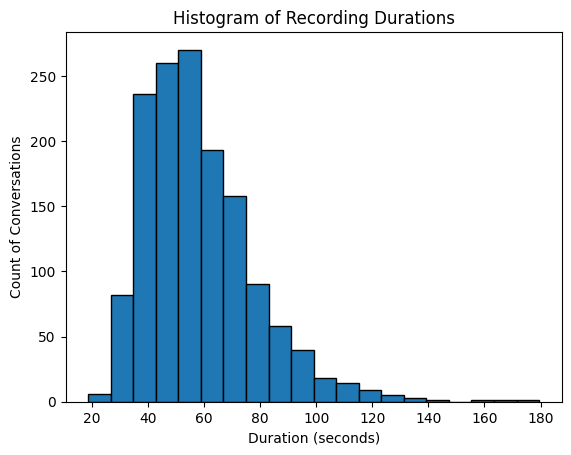

In [9]:
def recording_time(path_dir: str) -> Tuple[float, np.ndarray]:
  """Gets duration of recording
  Args:
    path_dir: Path to relevant directory.

  Returns:
    Duration of total recording in seconds (float),
    Numpy array of duration of recording for all conversations
  
  """
  
  #############################
  #### YOUR CODE GOES HERE ####
  total_duration = 0.0
  durations = []
    
  for filename in os.listdir(path_dir):
    if filename.endswith(".wav"):
        file_path = os.path.join(path_dir, filename)
        _, audio_data = wavfile.read(file_path)
        duration = len(audio_data) / float(_)
        total_duration += duration
        durations.append(duration)

  return total_duration, np.array(durations)
  #############################   

path_agent = agent_audio_path 
path_caller = caller_audio_path 

print("Duration of recordings in seconds " + str(recording_time(path_agent)[0]))

# Plot histogram: X - Duration of recording of individual file, Y - Count of audio files
############################# 
#### YOUR CODE GOES HERE ####
# Plot histogram: X - Duration of recording of individual file, Y - Count of audio files
plt.hist(recording_time(path_agent)[1], bins=20, edgecolor='black')
plt.title('Histogram of Recording Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count of Conversations')
plt.show()
#############################

## Transcript Analysis

**Transcripts:** The transcript json files are lists of segments where each segment is a json object with the following schema:

```json
{
    "channel_index": 2,
    "dialog_acts": [
        "gridspace_greeting"
    ],
    "duration_ms": 2280,
    "emotion": {
        "neutral": 0.33766093850135803,
        "negative": 0.024230705574154854,
        "positive": 0.6381083130836487
    },
    "human_transcript": "hello this is harper valley national bank",
    "index": 1,
    "offset_ms": 5990,
    "speaker_role": "agent",
    "start_ms": 3990,
    "start_timestamp_ms": 1591056064136,
    "transcript": "hello this is harper valley national bank",
    "word_durations_ms": [
        330,
        150,
        120,
        330,
        270,
        420,
        330
    ],
    "word_offsets_ms": [
        0,
        660,
        810,
        930,
        1260,
        1530,
        1950
    ]
}
```
The fields we will closely analyze for inference are:

- **"human_transcript":** Corrected version of the machine genereated "transcript".

- **"emotion":** Softmax output of Gridspace's Emotion model, determining whether the emotional valence of the segment was positive, negative, or neutral.

- **"dialog_acts":**. List of tags assigned to each utterance corresponding to types of conversational move represented in the utterance. There are 16 total dialog actions, and more than one can be present in an utterance. The 16 possible actions are: “yes” response, greeting, response, data confirmation, procedure explanation, data question, closing, data communication, “bear with me” response, acknowledgement, data response, filler disfluency, thanks, open question, problem description, and other.



##### <ins>**Task 1.2**</ins>**: Transcript Statistics (3 points)**

Load all transcript json files using `json.load()` and fill out the function `transcript_statistics` to get the following statistics: 
- Total number of utterances
- Mean number of agent utterances per conversation
- Mean number of caller utterances per conversation
- Total number of words: Keep in mind that "[", "]", "<", ">" aren't considered as words. 
- Number of unique words 

You can get the text of the audio file by looking at the **"human_transcript"** field for each transcript. You can use `word_tokenize` function from `nltk.tokenize`.  

In [15]:
def transcript_statistics(path_transcript: str) -> Tuple[int, float, float, int, int]:
    """Get transcript statistics.
    
    Args:
    path_transcript: Path to transcript directory.
    
    Returns:
    Total number of utterances, Mean number of agent utterances per conversation,
    Mean number of caller utterances per conversation, total number of words, 
    Number of unique words 
    """
    #############################
    #### YOUR CODE GOES HERE ####
    total_utterances = 0
    total_agent_utterances = 0
    total_caller_utterances = 0
    total_words = 0
    unique_words = set()

    for filename in os.listdir(path_transcript):
        if filename.endswith(".json"):
            file_path = os.path.join(path_transcript, filename)
            with open(file_path, 'r') as file:
                transcript_data = json.load(file)[0]
                total_utterances += 1
        
                # Extract information from the transcript_data
                speaker_role = transcript_data.get("speaker_role", "")
                human_transcript = transcript_data.get("human_transcript", "")
        
                # Tokenize words using nltk
                words = word_tokenize(human_transcript)
        
                total_words += len(words)
                unique_words.update(words)
        
                if speaker_role == "agent":
                    total_agent_utterances += 1
                elif speaker_role == "caller":
                    total_caller_utterances += 1
    
    mean_agent_utterances = total_agent_utterances / total_utterances if total_utterances > 0 else 0.0
    mean_caller_utterances = total_caller_utterances / total_utterances if total_utterances > 0 else 0.0
    
    return total_utterances, mean_agent_utterances, mean_caller_utterances, total_words, len(unique_words)
  #############################   

In [16]:
transcript_statistics(transcript_path)

(1446, 0.8022130013831259, 0.19778699861687413, 16414, 101)

##### <ins>**Task 1.3**</ins>**: Distribution of Utterances (3 points)**

Plot the distribution of number of utterances per conversation and tell us the average number of utterances per conversation. (`X`: Number of utterances in a transcript, `Y`: Number of transcipts with `x` number of utterances)

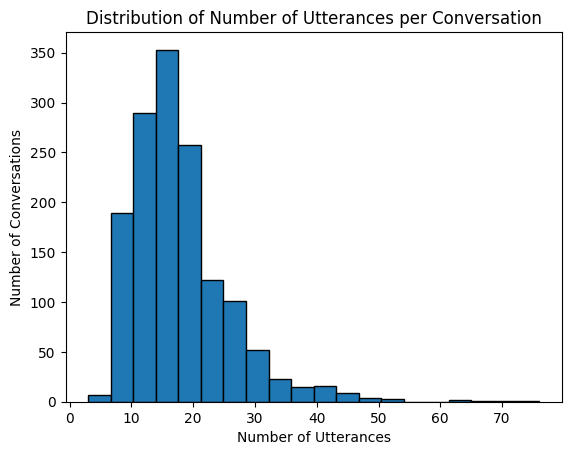

In [21]:
num_utterances = []
#############################
#### YOUR CODE GOES HERE ####

total_utterances, mean_agent_utterances, mean_caller_utterances, total_words, unique_words = transcript_statistics(transcript_path)

# Collect the number of utterances for each conversation
num_utterances = []

for filename in os.listdir(transcript_path):
    if filename.endswith(".json"):
        file_path = os.path.join(transcript_path, filename)
        with open(file_path, 'r') as file:
            transcript_data = json.load(file)
            num_utterances.append(len(transcript_data))

# Plot the distribution of the number of utterances per conversation
plt.hist(num_utterances, bins=20, edgecolor='black')
plt.title('Distribution of Number of Utterances per Conversation')
plt.xlabel('Number of Utterances')
plt.ylabel('Number of Conversations')
plt.show()

############################# 

##### <ins>**Task 1.4**</ins>**: Distribution of Tasks (2 points)**

Plot histogram of the distribution of tasks. The metadata files describe the call center scenario for each converstaion. We will look at **tasks** field for further inference. 

**tasks:** field indicates the customer’s goal/intent in the conversation. There are 8 tasks: _order checks, check balance, replace card, reset password, get branch hours, pay bill, schedule appointment, and transfer money_. (`X`: Eight tasks, `Y`: Number of conversations) 

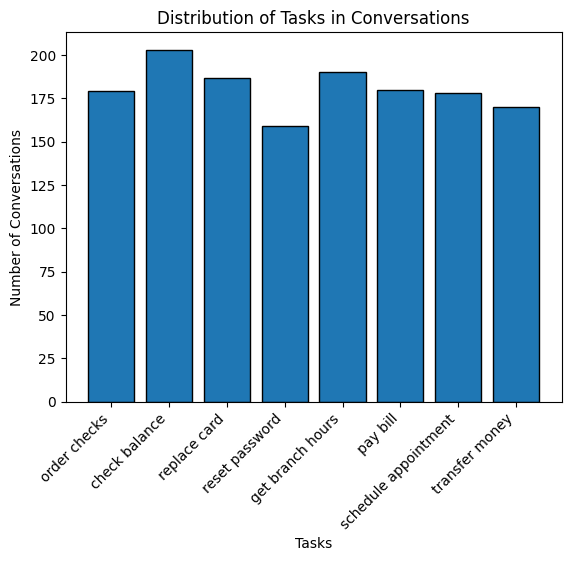

In [31]:
task_names = ['order checks', 'check balance', 'replace card', 'reset password', 'get branch hours', 'pay bill', 'schedule appointment', 'transfer money']

#############################
#### YOUR CODE GOES HERE ####
def get_task_distribution(path_metadata: str) -> dict:
    task_distribution = {task: 0 for task in task_names}

    for filename in os.listdir(path_metadata):
        if filename.endswith(".json"):
            file_path = os.path.join(path_metadata, filename)
            with open(file_path, 'r') as file:
                metadata = json.load(file)
                tasks = metadata.get("tasks", [])

                for task in tasks:
                    task_type = task.get("task_type", "")
                    if task_type in task_distribution:
                        task_distribution[task_type] += 1

    return task_distribution

# Example usage:
path_metadata = metadata_path

task_distribution = get_task_distribution(path_metadata)


# Plot histogram of the distribution of tasks
plt.bar(task_distribution.keys(),task_distribution.values(), align='center', edgecolor='black')
plt.title('Distribution of Tasks in Conversations')
plt.xlabel('Tasks')
plt.ylabel('Number of Conversations')
plt.xticks(rotation=45, ha='right')
plt.show()
############################# 

##### <ins>**Task 1.5**</ins>**: Distribution of Dialog Actions (2 points)**

Plot histogram the distribution of dialog actions for utterances. Use **"dialog_acts"** field from each transcript json files. What can you infer from this plot? Please remove "gridspace_" from the labels. (e.g. "greeting" instead of "gridspace_greeting")

(`X`: Dialogue action classes, `Y`: Number of utterances) 

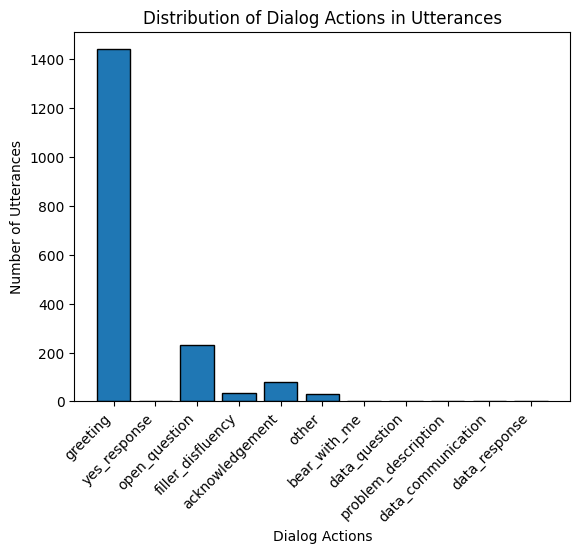

In [33]:
#############################
#### YOUR CODE GOES HERE ####
def get_dialog_action_distribution(path_transcript: str) -> dict:
    dialog_action_distribution = {}

    for filename in os.listdir(path_transcript):
        if filename.endswith(".json"):
            file_path = os.path.join(path_transcript, filename)
            with open(file_path, 'r') as file:
                transcript_data = json.load(file)[0]
                dialog_acts = transcript_data.get("dialog_acts", [])

                for dialog_act in dialog_acts:
                    # Remove "gridspace_" from the labels
                    dialog_act = dialog_act.replace("gridspace_", "")
                    if dialog_act in dialog_action_distribution:
                        dialog_action_distribution[dialog_act] += 1
                    else:
                        dialog_action_distribution[dialog_act] = 1

    return dialog_action_distribution

# Example usage:
path_transcript = transcript_path

dialog_action_distribution = get_dialog_action_distribution(path_transcript)

# Plot histogram of the distribution of dialog actions
plt.bar(dialog_action_distribution.keys(), dialog_action_distribution.values(), align='center', edgecolor='black')
plt.title('Distribution of Dialog Actions in Utterances')
plt.xlabel('Dialog Actions')
plt.ylabel('Number of Utterances')
plt.xticks(rotation=45, ha='right')
plt.show()
############################# 

##### <ins>**Task 1.6**</ins>**: Distribution of Emotions (2 points)**

Plot boxplots that show distribution of probabilities for each emotion category across utterances. Use **"emotion"** field from each transcript json files. What can you infer from this plot? (`X`: Emotion Classes, `Y`: Probability) 



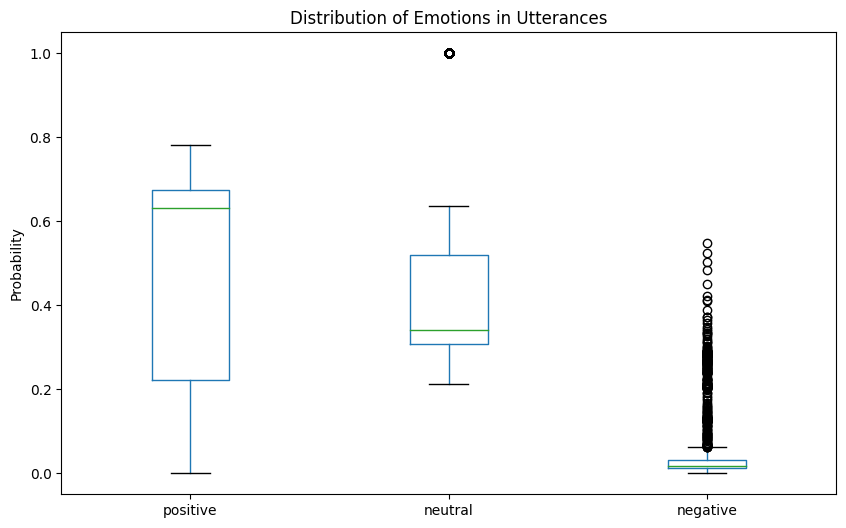

In [35]:
import pandas as pd

#############################
#### YOUR CODE GOES HERE ####
def get_emotion_data(path_transcript: str) -> pd.DataFrame:
    emotion_data = []

    for filename in os.listdir(path_transcript):
        if filename.endswith(".json"):
            file_path = os.path.join(path_transcript, filename)
            with open(file_path, 'r') as file:
                transcript_data = json.load(file)[0]
                emotion = transcript_data.get("emotion", {})

                # Append emotion data to the list
                emotion_data.append(emotion)

    # Convert the list of dictionaries to a DataFrame
    emotion_df = pd.DataFrame(emotion_data)

    return emotion_df

# Example usage:
path_transcript = transcript_path

emotion_df = get_emotion_data(path_transcript)

# Plot boxplots for the distribution of probabilities for each emotion category
plt.figure(figsize=(10, 6))
emotion_df.boxplot(column=['positive', 'neutral', 'negative'], grid=False)
plt.title('Distribution of Emotions in Utterances')
plt.ylabel('Probability')
plt.show()
############################# 

# Part 2: Implementing CTC Loss

We introduce the Connectionist Temporal Classification (CTC) objective, which is a popular objective used to train neural networks to do speech recognition. Critically, it does not require you to know the alignments between inputs and outputs.

#### **Summary of CTC**

We highlight some of the main features of the CTC objective.

- Given a sequence of inputs `x_1, x_2, .., x_T`, an ASR model will map each of these to a probability of an alphabet of C tokens: `p_1, p_2, ..., p_T`. For example, if we are decoding to three possible characters, the probabilities for timestep `t` could look like `p_t = [0.3, 0.2, 0.5]`.

- We also have a sequence of symbol targets `y_1, y_2, ..., y_S` (note `S <= T`). Each `y_s` is a number from `0` to `C-1` (e.g. one of the characters).

- The main strategy is to decode each `x_t` to a predicted character `y'_t`. For example, `x_1, x_2, ..., x_6 -> c c a a a t`. This mapping is called an **alignment**. Then we can collapse repetitions to get `c a t` as the predicted output sequence. This simple strategy has some problems: how do you handle silences or repeated characters?

- CTC adds a special `blank` token. We'll call this `eps`. Now consider this example, `x_1, x_2, ..., x_12 -> h h e eps eps l l l eps l l o`. Now we can collapse everything in between each `eps` to get `h e eps l eps l o`. Removing blank tokens, we get the prediction `hello`.

- For an output sequence, there are many "valid" alignments. For example, given an input sequence `x_1, ..., x_6` and an output sequence `c a t`, valid alignments include `eps c c eps a t`, `c c a a t t`, or `c a eps eps eps t`. Example of invalid alignments include `c eps c eps a t`, `c c a a t` (too short if the input sequence has 6 tokens), and `c eps eps eps t t`.

- Let `A` represent all valid alignments of an output sequence to an input sequence. A simplified pseudocode for the CTC objective might look like:

```
all_log_prob = 0

for each (a_1, a_2, ..., a_S) in A:

    log_prob = 0

    for t in 1 to T:
        # The alignment a_s has a specific output character for input position t
        log_prob_t = log p(a_(s,t) | x_1, ..., x_T)
        # compute the joint probability by multiplying independent time steps
        # Adding in log space to avoid underflow
        log_prob += log_prob_t

    all_log_prob += log_prob
```
That is, the CTC loss computes the probability of all possible alignments. Please note that the pseudocode above is for intuition. In practice, it is often too slow to enumerate over `A` explicitly. 

As an example, for an output sequence of length 50 (without any repeated characters) and an input sequence of length 100, the number of unique alignments is almost 10^40. 

#### **Dynamic Programming in CTC**

In class, we introduced the "forward algorithm" to tractably compute likelihoods for HMMs. We can do something similar to score alignments more efficiently than manually enumerating over the full set.

In other words, we can do dynamic programming. Since many alignments share partial sub-sequences, we can  store the `log_prob` for all sub-sequences we have seen so far. This allows us to reuse computation when computing the likelihood for a new sequence.

The logic is as follows:

Recall `X` is the input sequence of maximum length `T` and `Y` is the output sequence of maximum length `S`. Build a new sequence `Z` that adds a blank token between every character. 

```
Y = [y_1, y_2, ..., y_S]
Z = [eps, y_1, eps, y_2, ..., eps, y_S, eps]
  = [z_1, z_2, z_3, z_4, ..., z_2S-1, z_2S, z_2S+1]
```
Note that the length of `Z` is now `2S+1`.

**Step 1: Make a Cache.** 

Instantiate a matrix of size `T x (2S+1)`. Call this matrix `C`. The index `C[t][s]` represents a probability score for the subsequence `z_1, ..., z_s` after observing `x_1, ..., x_t`. That is, `C[t][s] = p(y_1, ..., y_s/2 | x_1, ..., x_t)`.

**Step 2: Make an Update Rule.**

The goal of dynamic programming is to reuse `C[t-1]` in computing `C[t]`. To do that, we need to define an update rule. There are two cases depending on what  the token `z_s` is.

- <ins>Case 1</ins>: `z_s` is a blank token OR `z_s = z_s-2`. This is the standard forward algorithm update. We build `p(z_1, ..., z_s|x_1, ..., x_t)` using two parts: `p(z_1, ..., z_s|x_1, ..., x_t-1)` and `p(z_1, ..., z_s-1|x_1, ..., x_t-1)`. Assuming an increasing order of `t` and `s`, these two parts will already have been computed. (If `s = 0` you can ignore the `C[t-1][s-1]` term. If `t = 0`, set `C[t][s] = p(z_s | x_1, ..., x_t)`.)
```
C[t][s] = (C[t-1][s-1] + C[t-1][s]) * p(z_s | x_1, ..., x_t)
```
In other words, `C[t-1][s-1]` and `C[t-1][s]` are known. The prediction for `p(z_s | x_1, ..., x_t)` is known (e.g. `log_probs`).

- <ins>Case 2</ins>: `z_s` is not a blank token AND `z_s != z_s-2`. The tricky part is to notice that `z_s-1` is a blank token. Since our Markov assumption says `y_t` should depend on `y_t-1`, which means `z_s` should depend on both `z_s-1` and `z_s-2` (since we artificially added `z_s-1`). Similarly, ignore terms that do not exist.
```
C[t][s] = (C[t-1][s-2] + C[t-1][s-1] + C[t-1][s]) * p(z_s | x_1, ..., x_t)
```

Now, we still need two for loops to loop over `1 ... T` and `1 ... S` but this is usually much cheaper than looping over alignments.

```
C = init_cache(T, S)
for t in 1 to T:
  for s in 1 to 2S+1:
    C = do_update(t, s, C)

p_y_given_x = C[-1][-1] + C[-1][-2]  # sum the probability of the last epsilon and last non-epsilon tokens
```

For more information, refer to this [blog](https://distill.pub/2017/ctc/) or the original [paper](https://www.cs.toronto.edu/~graves/icml_2006.pdf) by Alex Graves.



Please write a function in PyTorch that given a minibatch of model predicted probabilities and a minibatch of output sequences, computes the CTC objective.

**Note:** You cannot use the built-in `F.ctc_loss` in PyTorch. We will use this fast library for experiments in HW4.



In [44]:
def ctc_loss(
    log_probs: torch.FloatTensor, 
    targets: torch.LongTensor,
    input_lengths: torch.LongTensor, 
    target_lengths: torch.LongTensor,
    blank: int = 0
) -> torch.Tensor:
    """Connectionist Temporal Classification implementation.
    
    Args:
        log_probs: The log-beliefs returned by an ASR model.
          This is `log p(a_t | x_1, ..., x_T)`.
          (Shape: T x batch_size x C, where T is a maximum input sequence length and
          C is the alphabet size (including blank))
        
        targets: Sequence of contiguous output labels (no blanks).
          This is `y_1, ..., y_S`.
          (Shape: batch_size x S, where S is a maximum output sequence length)
        
        input_lengths: Lengths of each example in minibatch (<= T).
          (Shape: batch_size)
        
        target_lengths: Lengths of each target in minibatch (<= S).
          (Shape: batch_size)
        
        blank: The "epsilon" token that is used to represent silence.
          (integer <= C, default 0)
    
    Returns:
        CTC loss averaged over minibatch.
    """
    #############################
    #### YOUR CODE GOES HERE ####
    T, batch_size, C = log_probs.shape
    S = targets.size(1)

    # Initialize cache matrix C with zeros
    C = torch.zeros((T, 2*S + 1, batch_size), dtype=log_probs.dtype)

    # Initialize the first column (t=0)
    C[0, 0, :] = log_probs[0, :, blank]

    for t in range(1, T):
        for s in range(2*S + 1):
            if s == 0:
                C[t, s, :] = C[t-1, s, :] + log_probs[t, :, blank]
            elif s % 2 == 1:
                z_s = (s + 1) // 2
                if z_s <= target_lengths.max():  # Fix the condition
                    y_t = targets[:, z_s-1]
                    C[t, s, :] = C[t-1, s-2, :] + C[t-1, s-1, :] + C[t-1, s, :]
                    C[t, s, :] += log_probs[t, torch.arange(batch_size), y_t]
                else:
                    C[t, s, :] = C[t-1, s-2, :] + C[t-1, s-1, :] + C[t-1, s, :]
            else:
                z_s = s // 2
                if z_s <= target_lengths.max():  # Fix the condition
                    y_t = targets[:, z_s - 1]
                    C[t, s, :] = (C[t-1, s-1, :] + C[t-1, s, :]) * log_probs[t, torch.arange(batch_size), y_t]
                else:
                    C[t, s, :] = C[t-1, s-1, :] + C[t-1, s, :]

    # Calculate the final loss
    p_y_given_x = C[input_lengths-1, 2 * target_lengths, torch.arange(batch_size)] + C[input_lengths-1, 2 * target_lengths-1, torch.arange(batch_size)]
    loss = -p_y_given_x.sum() / batch_size

    return loss
  #############################
  

Here is a good sanity check. Test you code by checking below that `test` and `soln` are roughly equal. It's okay if your solution is much slower since the Pytorch one is coded in C. However, we will deduct points if you enumerate over all alignments as this is too slow for practical use.



In [45]:
import torch
import torch.nn.functional as F

log_probs = torch.randn(50, 16, 20).log_softmax(2).detach().requires_grad_()
targets = torch.randint(1, 20, (16, 30), dtype=torch.long)
input_lengths = torch.full((16,), 50, dtype=torch.long)
target_lengths = torch.randint(10,30,(16,), dtype=torch.long)

est = ctc_loss(log_probs, targets, input_lengths, target_lengths, blank=0)
soln = torch.mean(F.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank=0, reduction='none'))

print(est.detach().numpy(), soln.detach().numpy())

-3.3702872e+29 114.24989


##### <ins>**Task 2.1**</ins>**: Implement CTC on your own and demonstrate your implementation [15 points]**

Print your loss function results on the log_probs and targets we provide. You can load the test minibatches by calling `get_test_minibatches()`.


In [46]:
import torch
import torch.nn.functional as F
import random

def get_test_minibatches() -> list:
  """Get minibatches to test implementation
  Returns:
    lists of log_probs, targets, input_lengths, target_lengths
  """
  torch.manual_seed(224)
  np.random.seed(224)
  random.seed(224)

  T = np.array([])
  C = np.array([])
  N = np.array([])  
  S = 40  # Target sequence length of longest target in batch (padding length)
  for i in range(10):
    T = np.append(T, random.randint(i+50, i+80))
    C = np.append(C, random.randint(int(0.4* T[i]), int(0.8*T[i])))
    N = np.append(N, random.randint(int(0.7 *C[i]), int(0.9*C[i])))
      
  log_probs = []
  input_lengths = []
  target_lengths = [] # 10 x N[i]
  targets = []
  for i in range(10):
    log_probs.append(torch.randn(int(T[i]), int(N[i]), int(C[i])).log_softmax(2).detach().requires_grad_())
    input_lengths.append(torch.full((int(N[i]),), fill_value = int(T[i]), dtype=torch.long))
    target_lengths.append(torch.randint(low = 1,high = S, size = (int(N[i]),), dtype=torch.long))
    targets.append(torch.randint(low = 1, high = int(C[i]), size = (int(N[i]), S), dtype=torch.long))

  return log_probs, targets, input_lengths, target_lengths

In [47]:
log_probs, targets, input_lengths, target_lengths = get_test_minibatches()

In [69]:
#############################
#### YOUR CODE GOES HERE ####

def ctc_loss(log_probs, targets, input_lengths, target_lengths):
    """CTC loss calculation

    Args:
        log_probs: (Batch, Time, Class) log softmax outputs
        targets: (Batch, Time) ground truth labels
        input_lengths: (Batch,) lengths of the inputs
        target_lengths: (Batch,) lengths of the targets
    Returns:
        loss: total CTC loss
    """
    
    batch_size = len(log_probs)
    
    # # Flatten targets and remove blank labels
    # targets = targets.view(-1)
    # target_mask = (targets != 0).float()
    # targets = targets * target_mask

    # Calculate CTC loss  
    loss = 0
    for b in range(batch_size):
        input_length = input_lengths[b][0].item() 
        target_length = target_lengths[b][0].item()
        
        # Crop log probs to input length
        log_probs_b = log_probs[b]
        
        # Crop targets to target length
        targets_b = targets[b]
        # Flatten and remove blanks for this target tensor
        targets_b = targets_b.view(-1) 
        target_mask = (targets_b != 0).float()
        targets_b = targets_b * target_mask
        
        # Calculate forward-backward variables
        alphas = log_probs_b.new_zeros((target_length, log_probs_b.size(1)))
        betas = log_probs_b.new_zeros((target_length, log_probs_b.size(1)))
        
        # Initialize base cases 
        alphas[0,:] = log_probs_b[0,:] 
        betas[-1,:] = log_probs_b[-1,:]
        
        # Forward recursion
        for t in range(1, target_length):
            alphas[t] = log_softmax(log_probs_b[t] + alphas[t-1])
        
        # Backward recursion 
        for t in reversed(range(target_length - 1)):
            betas[t] = log_softmax(log_probs_b[t+1] + betas[t+1])
        
        # Calculate CTC score
        score = alphas + betas
        score = score * targets_b[:, None]
        score = log_softmax(score)
        score = torch.gather(score, 1, targets_b[:, None])
        
        # Sum across time
        score = score.sum()
        
        # Average across batch
        loss -= score / batch_size
        
    return loss

# Demonstration
log_probs, targets, input_lengths, target_lengths = get_test_minibatches()
loss = ctc_loss(log_probs, targets, input_lengths, target_lengths)
print("CTC loss:", loss.item())
############################# 

RuntimeError: expand(torch.FloatTensor{[21, 26]}, size=[21]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

This is the end of Part 1 & 2. Great work! 